In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.cross_decomposition import CCA
from scipy.signal import kaiserord, lfilter, firwin, freqz, butter, filtfilt, convolve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Load Dataset

In [58]:
dataset_name = "recordings/eeg_peter_new_" # 0 to 3
num_targets = 4
targets = [None] * num_targets
channels = ['P7', 'O1', 'O2']#, 'P8'] # data channels
for i in range(num_targets):
    targets[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    targets[i]['Unnamed: 0'] = [i % 120 for i in range(len(targets[i].index))]
    targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)
targets[0].head

<bound method NDFrame.head of       Counter        P7        O1        O2        P8          TIME
0           0  4607.179  3946.154  3877.949  4318.974  1.607036e+09
1           1  4627.692  3964.103  3887.692  4328.205  1.607036e+09
2           2  4628.205  3965.641  3902.564  4330.769  1.607036e+09
3           3  4613.333  3949.744  3892.308  4330.769  1.607036e+09
4           4  4615.897  3940.513  3881.026  4338.462  1.607036e+09
...       ...       ...       ...       ...       ...           ...
3595      115  4627.179  3953.846  3862.051  4294.872  1.607036e+09
3596      116  4631.282  3957.436  3865.641  4298.974  1.607036e+09
3597      117  4636.923  3965.641  3877.949  4309.231  1.607036e+09
3598      118  4637.949  3965.128  3881.538  4308.205  1.607036e+09
3599      119  4637.436  3956.923  3871.282  4298.974  1.607036e+09

[3600 rows x 6 columns]>

In [59]:
def cut_uneven_datasets(df_list):
    # use this function if the datasets are of uneven length - chop to minimum df size
    cutoff_list = [len(df_list[i].index) for i in range(num_targets)]
    cutoff = min(cutoff_list)
    for i in range(len(cutoff_list)):
        keep_indicies = set(range(df_list[i].shape[0])) - set(range(cutoff, df_list[i].shape[0]))
        df_list[i] = df_list[i].take(list(keep_indicies))
        # make sure each df same length
        print('new length of dataset {} = {}'.format(i+1, len(df_list[i].index)))
    return df_list
        
# check size - make sure each target is the same length
for i in range(num_targets):
    print('length target {} = {}'.format(i, len(targets[i].index)))

# fix length
targets = cut_uneven_datasets(targets)

length target 0 = 3600
length target 1 = 3600
length target 2 = 3600
length target 3 = 3600
new length of dataset 1 = 3600
new length of dataset 2 = 3600
new length of dataset 3 = 3600
new length of dataset 4 = 3600


In [60]:
# copy unfiltered data
original_data = [None] * num_targets
for i in range(num_targets):
    original_data[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    original_data[i]['Unnamed: 0'] = [i % 120 for i in range(len(original_data[i].index))]
    original_data[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [61]:
channels = ['P7', 'O1', 'O2']#, 'P8']
my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:gray']
my_labels = ['Target 0', 'Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6', 'Target 7', 'Neutral Target']

def butter_band_targets(targets, low=0.16, high=20.0):
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] = butter_band(np.asarray(targets[i][channel]), lowcut=low, highcut=high)
    return targets

def butter_highpass_targets(targets):
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] = butter_highpass(np.asarray(targets[i][channel]))
    return targets

def butter_band(data, s_r=128.0, lowcut=0.16, highcut=50.0, order=5):
    # ------------------------------------------------
    # Create a butterworth bandpass filter and apply it to data.
    # ------------------------------------------------
    nyq = 0.5 * s_r
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    # data = data * 50  # amplify data
    return filtfilt(b, a, data)

def butter_highpass(data, cutoff=0.16, fs=128.0, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def car_filter_targets(targets):
    # common average reference filter
    # subtract average off all data - list of dataframes
    for i in range(num_targets):
        for channel in channels:
            targets[i][channel] -= np.average(np.asarray(targets[i][channel]))
    return targets

def car_filter_one_channel(data):
    # numpy array - num_samples in one channel
    return data - np.average(data)

In [62]:
def plot_time_all(data, start=0, end=1000, extend_title=''):
    # df plot
    for i in range(num_targets):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            data[i][channel][start:end].plot(y=channel, grid=True, title='Target {} Signal Over Time {}'.format(i, extend_title) if i != 8 else 'Neutral Target Signal')
        ax.legend(channels)
        ax.autoscale(axis='y', tight=True)
        
        
def plot_channel(target, channel):
    # assume dataframe
    fig, ax = plt.subplots(figsize=(10, 5))
    target[channel].plot(y=channel, grid=True, title='{} Signal Over Time'.format(channel))
        
def cut_ends(cutoff=256):
    # this function is used after FIR filtering because the ends have extremely high peaks
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)] + [i for i in range(n-1, n-cutoff-1, -1)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
def cut_left_end(cutoff=256):
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
def plot_power_all(data, extend_title=''):
    # plot power spectrum - list of df
    # use median average power spectrum
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
    for i in range(len(data)):
        for color, channel in enumerate(channels):
            sig = np.asarray(data[i][channel])
            freqs, pows = signal.welch(sig, 128.0, nperseg=128, average='median')
            axs.flatten()[i].plot(freqs, pows, label=channel, color=my_colors[color])
        axs.flatten()[i].set_yscale('log')
        axs.flatten()[i].grid()
        axs.flatten()[i].set_title('Target {} ({} Hz) Power Spectrum {}'.format(i, frequencies[i], extend_title))
        axs.flatten()[i].set_xlabel('Frequency (Hz)')
        axs.flatten()[i].set_ylabel('PSD (V^2/Hz)')
        axs.flatten()[i].legend()
    plt.show()

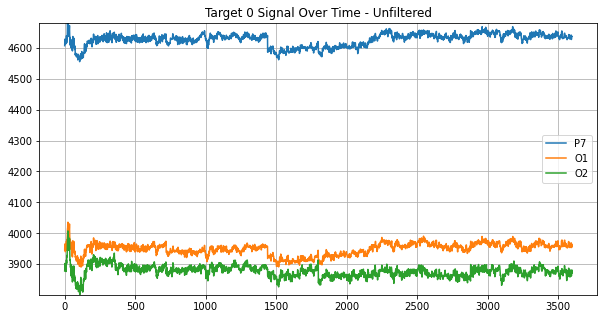

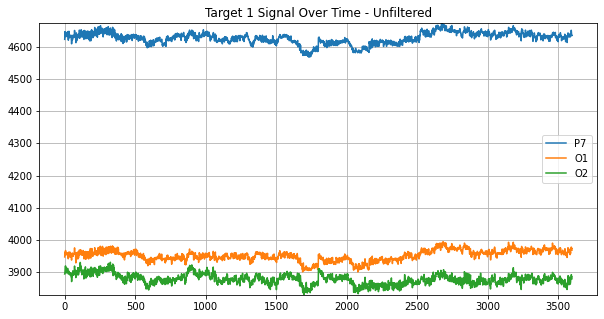

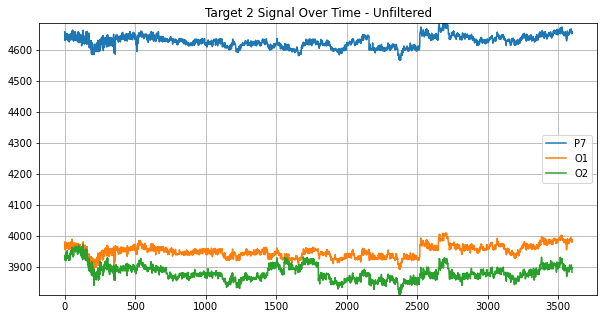

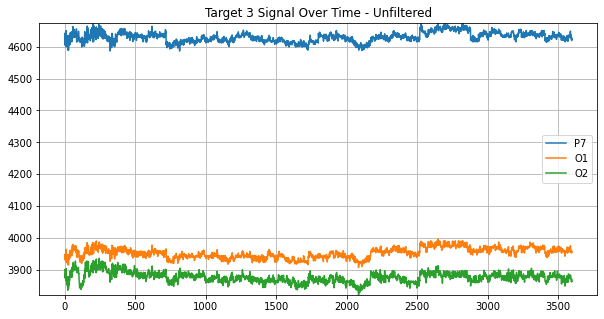

In [63]:
plot_time_all(targets, end=len(targets[0].index), extend_title='- Unfiltered')

In [64]:
frequencies = [15.0, 12.0, 8.57, 5.45]
targets = car_filter_targets(targets)
# targets = butter_highpass_targets(targets)
targets = butter_band_targets(targets)

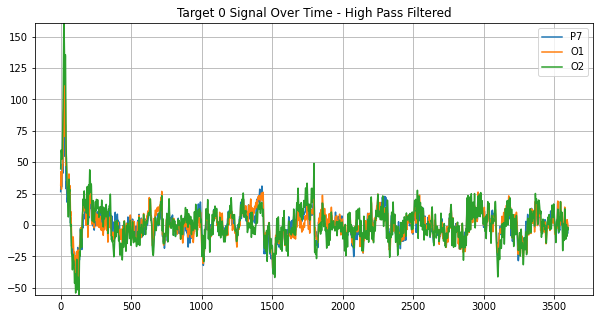

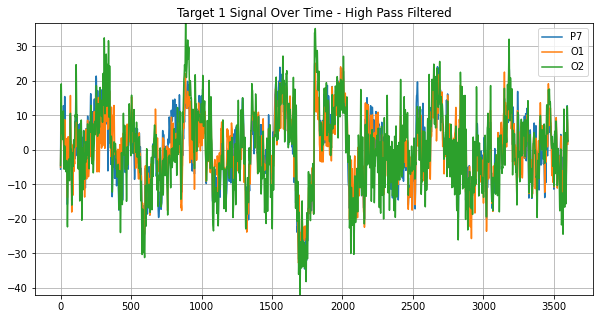

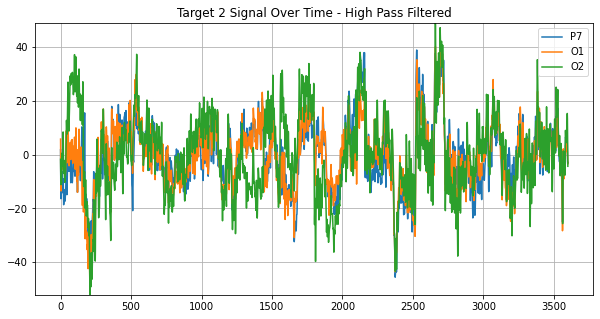

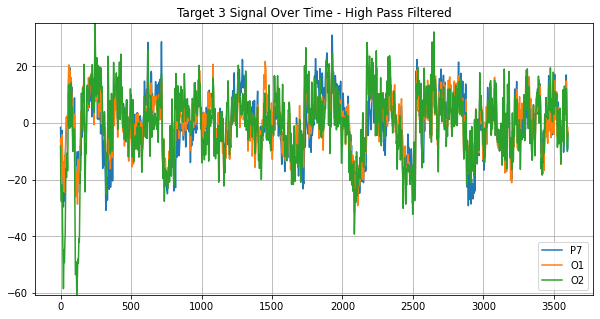

In [65]:
plot_time_all(targets, start=0, end=len(targets[0].index), extend_title='- High Pass Filtered')

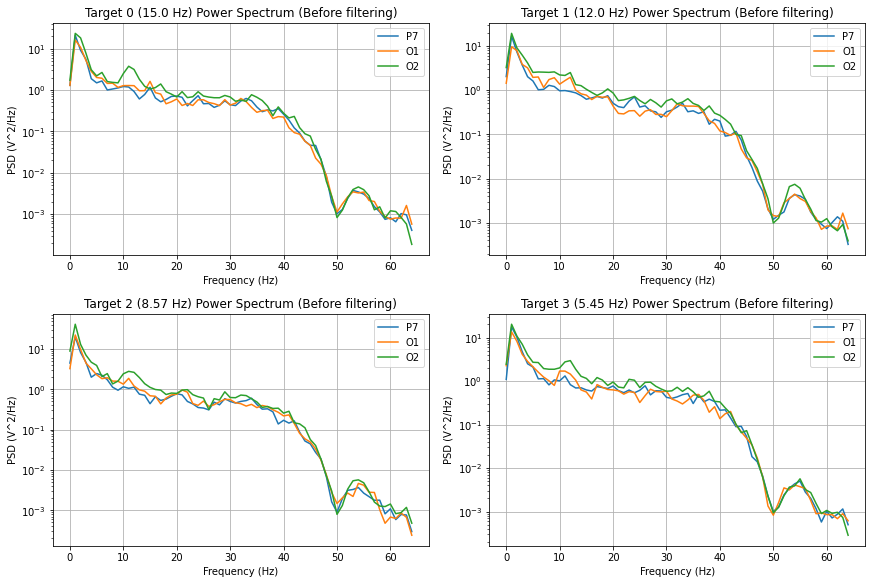

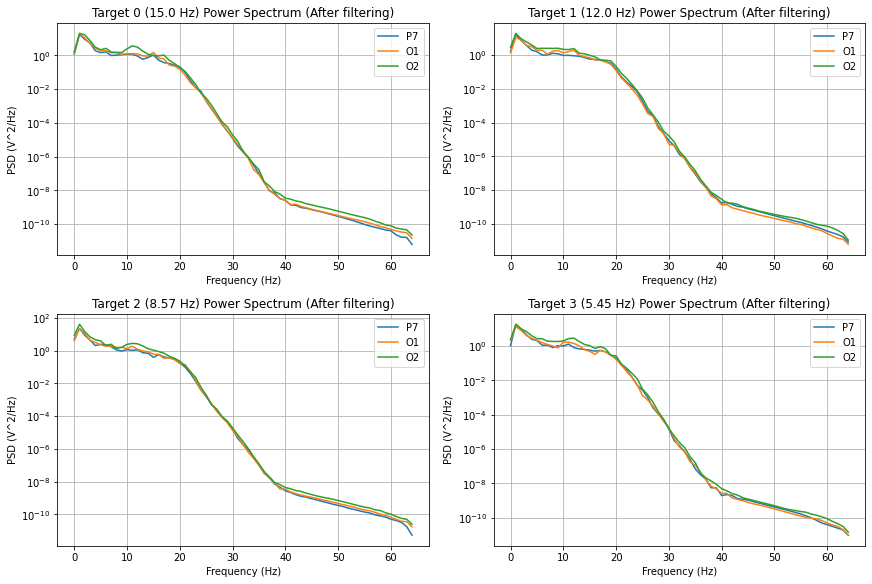

In [66]:
plot_power_all(original_data, extend_title='(Before filtering)') # unfiltered
plot_power_all(targets, extend_title='(After filtering)') # filtered

In [67]:
def getReferenceSignals(frequencies, num_seconds):
    ref_signals = []
    for freq in frequencies:
        ref_signals.append(generateRefSignal(128 * num_seconds, freq))
    return np.asarray(ref_signals)

def generateRefSignal(samples, freq):
    signals = []
    t = np.arange(0, (samples/128.0), step=1.0/128.0)
    signals.append(np.sin(np.pi*2*freq*t))
    signals.append(np.cos(np.pi*2*freq*t))
    signals.append(np.sin(np.pi*4*freq*t))
    signals.append(np.cos(np.pi*4*freq*t))

    return np.asarray(signals)

def findCorr(data, target):
    result = np.zeros([(target.shape)[0], 2]) # num_targets x number of canonical corrs
    cca = CCA(n_components=2)
    for i in range(0, (target.shape)[0]):
        cca.fit(data, np.squeeze(target[i,:,:]).T)
        a, b = cca.transform(data, np.squeeze(target[i,:,:]).T)
        # a and b shape = 128 x (n_components)
        # print('a shape {} \t b shape {}'.format(a.shape, b.shape))
        corr_arr0 = np.corrcoef(a[:,0], b[:,0])
        corr_arr1 = np.corrcoef(a[:,1], b[:,1])
        # print('target {}:\tcorr={}'.format(i, corr_arr0[0, 1]))
        # print('target {}:\tcorr0 = {}\tcorr1 = {}'.format(i, corr_arr0[0,1], corr_arr1[0,1]))
        corr = corr_arr0[0, 1]
        corr2 = corr_arr1[0, 1]
        result[i][0] = corr
        result[i][1] = corr2
    return result

def getChunkFeatures(data, ref_signals):
    corrs = findCorr(data, ref_signals)
    # print(corrs.flatten())
    return corrs.flatten(order='F')

In [24]:
def check_targets(num_seconds=2, cheating=False):
    # taking raw data from EEG, filtering it, making predictions, and generating CCA features
    num_chunks = len(original_data[0].index) // (128 * num_seconds)
    features = np.zeros([num_chunks * num_targets, 9])
    ref_signals = getReferenceSignals(frequencies, num_seconds=num_seconds)
    channels = ['P7', 'O1', 'O2', 'P8']
    chunk = 0
    for target in range(len(original_data)):
        predictions = []
        row = 0
        # print('\n' + '-'*20 + 'Checking Target {} against reference signals ... '.format(target) + '-'*20 + '\n')
        while True:
            if row >= len(original_data[target].index) or len(original_data[target].index) - row < 128 * num_seconds:
                # print("done checking targets. row at {}".format(row))
                break
            # print('Checking samples {} to {} ...'.format(row, row+128*num_seconds))
            data = np.asarray(original_data[target][channels][row:row+128*num_seconds]) # 128 x 4
            
            # filter chunk
            for i, channel in enumerate(data.T):
                
                if cheating:
                    band_edges = [frequencies[target] - 1.0, frequencies[target] + 1.0]
                    data.T[i] = butter_band(channel, lowcut=band_edges[0], highcut=band_edges[1])
                else:
                    # data.T[i] = butter_filter(channel)
                    channel = car_filter_one_channel(channel)
                    # data.T[i] = butter_highpass(channel)
                    data.T[i] = butter_band(channel, lowcut=0.16, highcut=20.0)

            features_row = getChunkFeatures(data, ref_signals)
            features_row = np.append(features_row, target)
            features[chunk] = features_row
            prediction = np.argmax(features_row[:4])
            # print("Predicted target {}".format(prediction))
            predictions.append(prediction)
            row += 128 * num_seconds
            chunk += 1
        accuracy = round(100 * predictions.count(target) / len(predictions))
        print('Accuracy for target {} against target {} reference signals = {} %'.format(target, target, accuracy))
    return features

In [25]:
def get_knn_accuracy(num_seconds, cheating=False):
    features = check_targets(num_seconds=num_seconds, cheating=cheating)
    # print('-'*20 + 'Performing KNN with {} second segments... '.format(num_seconds) + '-'*20)
    corrs = features[:, :-1]
    labels = [int(i) for i in features[:, -1]]
    X_train, X_test, y_train, y_test = train_test_split(corrs, labels, test_size=0.20)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    print('KNN Accuracy for {} seconds: '.format(num_seconds), metrics.accuracy_score(y_test, pred))
    # print('Predicted actions:')
    # print([int(i) for i in pred])
    # print('Correct actions:')
    # print([int(i) for i in y_test])
    print('\n')

In [27]:
get_knn_accuracy(num_seconds=1)
get_knn_accuracy(num_seconds=2)
get_knn_accuracy(num_seconds=3)

Accuracy for target 0 against target 0 reference signals = 7 %
Accuracy for target 1 against target 1 reference signals = 32 %
Accuracy for target 2 against target 2 reference signals = 21 %
Accuracy for target 3 against target 3 reference signals = 64 %
KNN Accuracy for 1 seconds:  0.13043478260869565


Accuracy for target 0 against target 0 reference signals = 7 %
Accuracy for target 1 against target 1 reference signals = 21 %
Accuracy for target 2 against target 2 reference signals = 14 %
Accuracy for target 3 against target 3 reference signals = 64 %
KNN Accuracy for 2 seconds:  0.4166666666666667


Accuracy for target 0 against target 0 reference signals = 0 %
Accuracy for target 1 against target 1 reference signals = 44 %
Accuracy for target 2 against target 2 reference signals = 11 %
Accuracy for target 3 against target 3 reference signals = 78 %
KNN Accuracy for 3 seconds:  0.5


